# Задание 1

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.8 MB/s eta 0:00:00


In [2]:
import os
import random
import numpy as np
import torch
import torchvision
from torch import nn, optim
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from torchmetrics.functional import accuracy
from torchvision.models import vgg16
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"

import warnings
warnings.filterwarnings('ignore')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

cifar_train = torchvision.datasets.CIFAR10(
    root="./cifar", train=True, download=True, transform=transform
)
cifar_val = torchvision.datasets.CIFAR10(
    root="./cifar", train=False, download=True, transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    cifar_train, batch_size=32, shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    cifar_val, batch_size=32, shuffle=False
)

100%|██████████| 170498071/170498071 [00:04<00:00, 40164568.36it/s]


Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


In [5]:
model = vgg16(pretrained = False)
model.classifier[6] = nn.Linear(4096, 10)

In [6]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [7]:
def fit(model, train_loader, criterion, optimizer):
    #accuracy = Accuracy(task="multiclass", num_classes=10)
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    for x_train, y_train in tqdm(train_loader):
        optimizer.zero_grad()
        pred = model(x_train.to(device))
        loss = criterion(pred, y_train.to(device))
        total_loss += loss.item()
        total_accuracy += accuracy(torch.argmax(pred.cpu(), dim=-1).long(), y_train.long(), task = 'multiclass', num_classes=10)
        #total_accuracy += accuracy(pred, y_train.to(device))
        #print(accuracy(pred, y_train.to(device)))
        #break
        #print(loss)
        loss.backward()
        optimizer.step()

    print(f'mean train loss: {total_loss / len(train_loader)}, mean train accuracy: {total_accuracy / len(train_loader)}')

In [8]:
def validation(model, test_loader, criterion):
  model.eval()
  predictions = []
  total_loss = 0.0
  total_accuracy = 0.0
  with torch.no_grad():
    for x_test, y_test in tqdm(test_loader):
      pred = model(x_test.to(device))
      loss = criterion(pred, y_test.to(device))
      total_loss += loss.item()
      total_accuracy += accuracy(torch.argmax(pred.cpu(), dim=-1).long(), y_test.long(), task = 'multiclass', num_classes=10)
      predictions.append(pred)

  print(f'mean test loss: {total_loss / len(test_loader)}, mean test accuracy: {total_accuracy / len(test_loader)}')
  return torch.cat(predictions)


In [9]:
def train(model, train_loader, test_loader, criterion, optimizer, n_epoch = 3):
  for epoch in range(n_epoch):
    print(f'epoch: {epoch + 1}')
    fit(model, train_loader, criterion, optimizer)
    validation(model, test_loader, criterion)

В целях экономии времени будем учиться всего на 3 эпохах. В целом, даже так получаем относительно неплохое accuracy на валидации - почти 0,7.

In [10]:
train(model.to(device), train_dataloader, val_dataloader, criterion, optimizer)

epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.7778641456834643, mean train accuracy: 0.3461892306804657


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.4791059318822795, mean test accuracy: 0.4600639045238495
epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.3535482503249716, mean train accuracy: 0.5051783323287964


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.1628007477464768, mean test accuracy: 0.5764776468276978
epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.1008363506081618, mean train accuracy: 0.6064059734344482


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 0.9288066039070154, mean test accuracy: 0.6749201416969299


In [ ]:
new_model = nn.Sequential(*list(model.children())[:-1])
new_model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def get_features(model, test_loader):
  all_features = []
  with torch.no_grad():
    for x_test, y_test in tqdm(test_loader):
      features = model(x_test.to(device))
      all_features.append(features)
  return torch.cat(all_features)


In [ ]:
features = get_features(new_model, val_dataloader)

  0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
features.size()

torch.Size([10000, 512, 7, 7])

In [ ]:
features = features.view(features.size(0), -1)

In [ ]:
features.size()

torch.Size([10000, 25088])

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2)
features_tsne = tsne.fit_transform(features.to('cpu'))

In [ ]:
features_tsne.shape

(10000, 2)

In [ ]:
target = torch.cat([y for _, y in val_dataloader])

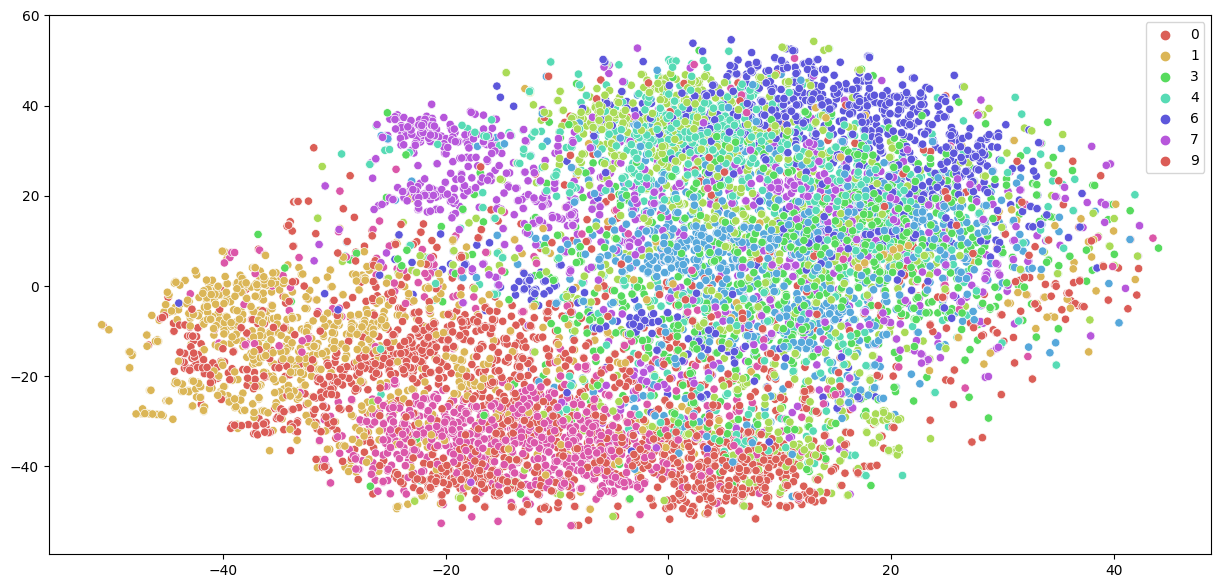

In [ ]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x = features_tsne[:, 0], y = features_tsne[:, 1], hue = target, palette='hls')
plt.show()

Если рисовать график расположения признаков одним цветом, то получается совсем какая-то каша из кружочков, поэтому я решила проверить следующую теорию - допустим, что у изображений с одинаковым таргетом будут похожие признаки(звучит, в общем-то, разумно). Решила отобразить это на графике - у каждого класса свой цвет. Несмотря на то, что некоторые тенденции в расположении классов прослеживаются(например, желтый класс преобладает в нижней левой части графика, розовый - снизу по центру, красный тянется по всей нижней половине иллюстрации и тд), картинка получается все равно не очень ясной, есть много наложений классов.

In [ ]:
y_val = validation(model.to(device), val_dataloader, criterion)

  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 0.9288066039070154, mean test accuracy: 0.6749201416969299


In [ ]:
y_val = torch.argmax(y_val, dim=1)

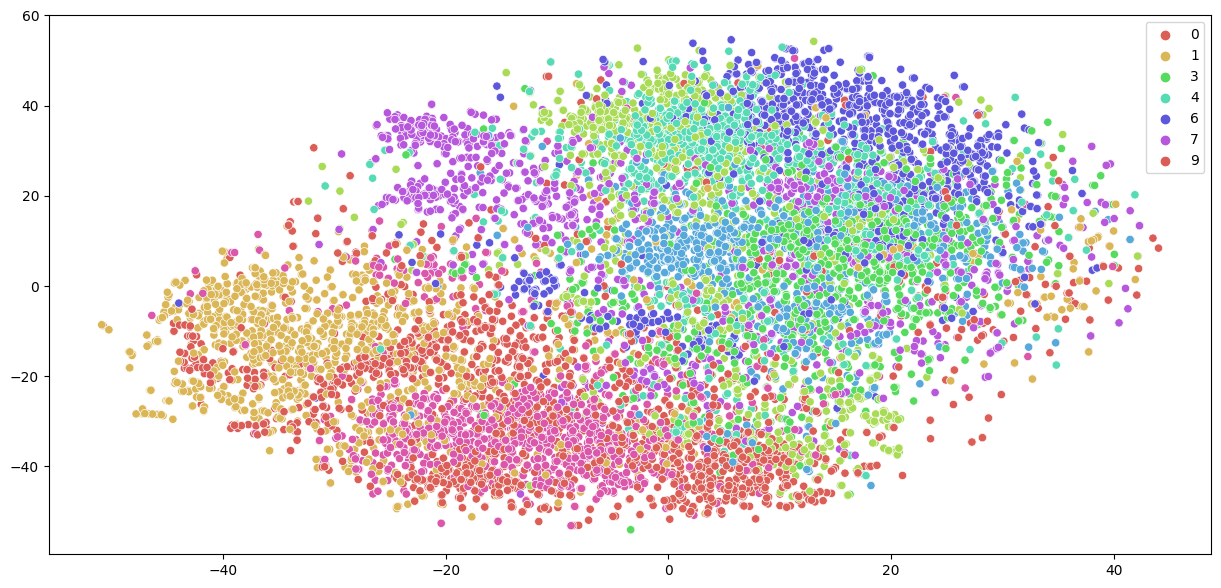

In [ ]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x = features_tsne[:, 0], y = features_tsne[:, 1], hue = y_val.cpu(), palette='hls')
plt.show()

Решила сопоставить признаки с предсказанным таргетом. Относительно разделения классов стало получше, но в целом картинка не особо поменялась.

Для сравнения посмотрим на два графика одновременно:

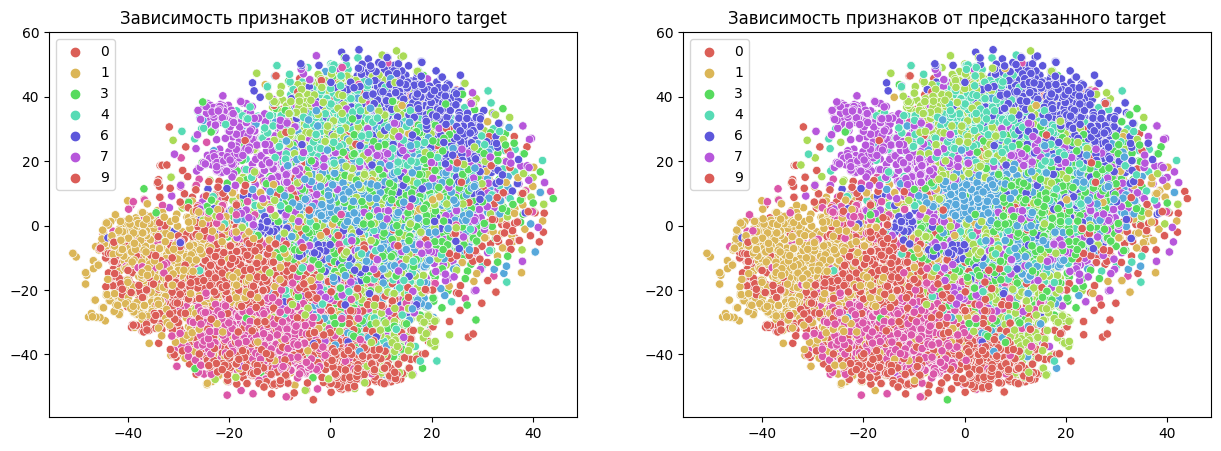

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x = features_tsne[:, 0], y = features_tsne[:, 1], hue = target, palette='hls')
plt.title('Зависимость признаков от истинного target')

plt.subplot(1, 2, 2)
sns.scatterplot(x = features_tsne[:, 0], y = features_tsne[:, 1], hue = y_val.cpu(), palette='hls')
plt.title('Зависимость признаков от предсказанного target')

plt.show()


# Задание 2

In [11]:
class DepthWiseConv(nn.Module):
    def __init__(self, nin, nout):
        super(DepthWiseConv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, stride = 1, padding=1, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
from copy import deepcopy

In [ ]:
experiment_1 = deepcopy(model)

for param in experiment_1.parameters():
  param.requires_grad = False

experiment_1.features[0] = DepthWiseConv(3, 64)

In [ ]:
experiment_1

VGG(
  (features): Sequential(
    (0): DepthWiseConv(
      (depthwise): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
      (pointwise): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [ ]:
optimizer_exp1 = optim.SGD(experiment_1.features[0].parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
train(experiment_1.to(device), train_dataloader, val_dataloader, criterion, optimizer_exp1)

epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.104250499245759, mean train accuracy: 0.6152831315994263


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.0079708869655293, mean test accuracy: 0.6443690061569214
epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 0.9788571460004503, mean train accuracy: 0.6548904180526733


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 0.9700515702509651, mean test accuracy: 0.6575479507446289
epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 0.9565696311317341, mean train accuracy: 0.6616082787513733


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 0.9581999339806005, mean test accuracy: 0.664536714553833


Уже на первой эпохе получилось достичь почти такого же качества, как у оригинальной модели после трех эпох обучения. На второй и третьей эпохах ошибка и точность на тесте становятся лучше, чем у оригинальной модели, но на валидации похуже. В целом, модель показывает качество на тесте лучше, чем оригинальная, на валидации примерно такое же. Оставим DepthWiseConv вместо обычной свертки.

In [ ]:
experiment_2 = deepcopy(experiment_1)

for param in experiment_2.parameters():
  param.requires_grad = False

experiment_2.features[2] = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)

optimizer_exp2 = optim.SGD(experiment_2.features[2].parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
train(experiment_2.to(device), train_dataloader, val_dataloader, criterion, optimizer_exp2)

epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.238272595008977, mean train accuracy: 0.5687379837036133


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.143843739939193, mean test accuracy: 0.6003394722938538
epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.1277249221685828, mean train accuracy: 0.6052463054656982


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.0969320305239278, mean test accuracy: 0.6126198172569275
epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.0882204583800152, mean train accuracy: 0.6177822947502136


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.068918631861385, mean test accuracy: 0.6209065318107605


На трейне ошибка и точность стали получше, но на валидации качество хуже, чем у оригинальной модели, причем значительно. Этот слой оставим простой сверткой.

In [ ]:
experiment_3 = deepcopy(experiment_1)

for param in experiment_3.parameters():
  param.requires_grad = False

experiment_3.features[5] = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)

optimizer_exp3 = optim.SGD(experiment_3.features[5].parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
train(experiment_3.to(device), train_dataloader, val_dataloader, criterion, optimizer_exp3)

epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.7024888953412105, mean train accuracy: 0.40696975588798523


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.5469337240956462, mean test accuracy: 0.46475639939308167
epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.5402075085057254, mean train accuracy: 0.4557741582393646


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.4630131580578252, mean test accuracy: 0.4894169270992279
epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.4832941159863389, mean train accuracy: 0.4757877588272095


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.4194095477509423, mean test accuracy: 0.5050918459892273


Стало только хуже :(

In [ ]:
experiment_4 = deepcopy(experiment_1)

for param in experiment_4.parameters():
  param.requires_grad = False

experiment_4.features[7] = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128)

optimizer_exp4 = optim.SGD(experiment_4.features[7].parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
train(experiment_4.to(device), train_dataloader, val_dataloader, criterion, optimizer_exp4)

epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.5900018591188272, mean train accuracy: 0.46279191970825195


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.3545196340106929, mean test accuracy: 0.5296525359153748
epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.3162938151615824, mean train accuracy: 0.5393673777580261


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.2738064973118206, mean test accuracy: 0.5545127987861633
epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.2592519751665918, mean train accuracy: 0.5538627505302429


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.238813540996454, mean test accuracy: 0.5622004866600037


После второй эпохи изменения и на тесте, и на трейне совсем незначительные(наверно, застряли в локальном минимуме, хотя на трех эпохах рано о таком судить), ошибка и точность хуже, чем у первого эксперимента.

In [ ]:
experiment_5 = deepcopy(experiment_1)

for param in experiment_5.parameters():
  param.requires_grad = False

experiment_5.features[10] = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, groups=128)

optimizer_exp5 = optim.SGD(experiment_5.features[10].parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
train(experiment_5.to(device), train_dataloader, val_dataloader, criterion, optimizer_exp5)

epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.686623045746821, mean train accuracy: 0.45401471853256226


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.3497806471376754, mean test accuracy: 0.5636980533599854
epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.2968487650708975, mean train accuracy: 0.5677983164787292


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.2331001255839777, mean test accuracy: 0.587260365486145
epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.2139067352008759, mean train accuracy: 0.5865923166275024


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.1761248604939007, mean test accuracy: 0.601138174533844


Опять видим значительные потери в точности

In [ ]:
experiment_6 = deepcopy(experiment_1)

for param in experiment_6.parameters():
  param.requires_grad = False

experiment_6.features[12] = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, groups=256)

optimizer_exp6 = optim.SGD(experiment_6.features[12].parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
train(experiment_6.to(device), train_dataloader, val_dataloader, criterion, optimizer_exp6)

epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 2.063328918019549, mean train accuracy: 0.2831093966960907


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.7093364438309837, mean test accuracy: 0.4802316427230835
epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.5396537753304684, mean train accuracy: 0.5328694581985474


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.4059214485339082, mean test accuracy: 0.5701876878738403
epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.3611325078184453, mean train accuracy: 0.5738163590431213


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.3001087605001065, mean test accuracy: 0.58805912733078


In [ ]:
experiment_7 = deepcopy(experiment_1)

for param in experiment_7.parameters():
  param.requires_grad = False

experiment_7.features[14] = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, groups=256)

optimizer_exp7 = optim.SGD(experiment_7.features[14].parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
train(experiment_7.to(device), train_dataloader, val_dataloader, criterion, optimizer_exp7)

epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 2.155216402909882, mean train accuracy: 0.25821736454963684


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 2.0399830333721902, mean test accuracy: 0.35463258624076843
epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.9440169391613775, mean train accuracy: 0.40139156579971313


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.8311884944050456, mean test accuracy: 0.45646965503692627
epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.7669250884272696, mean train accuracy: 0.47040948271751404


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.6850027036362183, mean test accuracy: 0.49610623717308044


Как-то совсем грустно становится...
На большем количестве эпох становится немного позитивнее(пробовала учить на 5), но того результата, который давал бы первый эксперимент, все равно не получается достичь

In [ ]:
experiment_8 = deepcopy(experiment_1)

for param in experiment_8.parameters():
  param.requires_grad = False

experiment_8.features[17] = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, groups=256)

optimizer_exp8 = optim.SGD(experiment_8.features[17].parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
train(experiment_8.to(device), train_dataloader, val_dataloader, criterion, optimizer_exp8)

epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 2.0770860312462465, mean train accuracy: 0.2967650294303894


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.901717690614085, mean test accuracy: 0.3874800205230713
epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.8282179895762214, mean train accuracy: 0.39533349871635437


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.7307170241023786, mean test accuracy: 0.4311102330684662
epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.7003360687733002, mean train accuracy: 0.4277831017971039


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.6221263621942685, mean test accuracy: 0.45617014169692993


In [ ]:
experiment_9 = deepcopy(experiment_1)

for param in experiment_9.parameters():
  param.requires_grad = False

experiment_9.features[19] = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, groups=512)

optimizer_exp9 = optim.SGD(experiment_9.features[19].parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
train(experiment_9.to(device), train_dataloader, val_dataloader, criterion, optimizer_exp9)

epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 2.2353025365928314, mean train accuracy: 0.19617722928524017


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 2.1534143057874977, mean test accuracy: 0.2761581540107727
epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 2.0777954167459383, mean train accuracy: 0.3125799596309662


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.967272842654024, mean test accuracy: 0.352835476398468
epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.915446589943391, mean train accuracy: 0.35648593306541443


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.8376403136756092, mean test accuracy: 0.3817891478538513


Мрак...

In [ ]:
experiment_10 = deepcopy(experiment_1)

for param in experiment_10.parameters():
  param.requires_grad = False

experiment_10.features[21] = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, groups=512)

optimizer_exp10 = optim.SGD(experiment_10.features[21].parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
train(experiment_10.to(device), train_dataloader, val_dataloader, criterion, optimizer_exp10, 5)

epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 2.1109972272404325, mean train accuracy: 0.26447537541389465


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.9647587198799792, mean test accuracy: 0.3419528901576996
epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.9072255635215773, mean train accuracy: 0.3433501422405243


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.8171688059267526, mean test accuracy: 0.38079074025154114
epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.789239819661517, mean train accuracy: 0.38291746377944946


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.7144987541265762, mean test accuracy: 0.4158346652984619
epoch: 4


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.7053952837173403, mean train accuracy: 0.4110884368419647


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.6385820167133223, mean test accuracy: 0.43959665298461914
epoch: 5


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.6404804475629322, mean train accuracy: 0.43172183632850647


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.5802590789886328, mean test accuracy: 0.46026358008384705


Даже при увеличении количества эпох не получается достигнуть качества, схожего с первым экспериментом. В целом, можно заметить, что чем "глубже" слой, который мы меняем, тем хуже становится качество модели

In [ ]:
experiment_11 = deepcopy(experiment_1)

for param in experiment_11.parameters():
  param.requires_grad = False

experiment_11.features[24] = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, groups=512)

optimizer_exp11 = optim.SGD(experiment_11.features[24].parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
train(experiment_11.to(device), train_dataloader, val_dataloader, criterion, optimizer_exp11)

epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 2.179338302889926, mean train accuracy: 0.23048624396324158


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 2.03314560442306, mean test accuracy: 0.32747602462768555
epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.97373459015759, mean train accuracy: 0.32063740491867065


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.8855398638179888, mean test accuracy: 0.3699081540107727
epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.8670608570998248, mean train accuracy: 0.34820857644081116


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.7965771275968216, mean test accuracy: 0.39496806263923645


In [ ]:
experiment_12 = deepcopy(experiment_1)

for param in experiment_12.parameters():
  param.requires_grad = False

experiment_12.features[26] = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, groups=512)

optimizer_exp12 = optim.SGD(experiment_12.features[26].parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
train(experiment_12.to(device), train_dataloader, val_dataloader, criterion, optimizer_exp12, 6)

epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 2.1591218235549148, mean train accuracy: 0.23482485115528107


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 2.0144245708331514, mean test accuracy: 0.34404951333999634
epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.9738148945078053, mean train accuracy: 0.31259995698928833


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.869511262677348, mean test accuracy: 0.3741014301776886
epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.8663904779016858, mean train accuracy: 0.3452894985675812


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.778536991189463, mean test accuracy: 0.3983626067638397
epoch: 4


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.8013131810698995, mean train accuracy: 0.3622440695762634


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.716511106719605, mean test accuracy: 0.417332261800766
epoch: 5


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.751126590174738, mean train accuracy: 0.37509995698928833


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.670494370567151, mean test accuracy: 0.43490415811538696
epoch: 6


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.7167310002364184, mean train accuracy: 0.38681623339653015


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.6354597997360718, mean test accuracy: 0.4444888234138489


In [ ]:
# ура, последний!
experiment_13 = deepcopy(experiment_1)

for param in experiment_13.parameters():
  param.requires_grad = False

experiment_13.features[28] = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, groups=512)

optimizer_exp13 = optim.SGD(experiment_13.features[28].parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
train(experiment_13.to(device), train_dataloader, val_dataloader, criterion, optimizer_exp13)

epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 2.150941931431063, mean train accuracy: 0.2177703082561493


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.909730155247088, mean test accuracy: 0.32937300205230713
epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.9101527591431973, mean train accuracy: 0.29798465967178345


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.7525782741296787, mean test accuracy: 0.3929712474346161
epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

mean train loss: 1.8078508354194334, mean train accuracy: 0.33605247735977173


  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 1.6704016893435591, mean test accuracy: 0.4282148480415344


In [ ]:
validation(experiment_1, val_dataloader, criterion)

# в конце вывелись предсказания для каждого изображения, не пугаемся

  0%|          | 0/313 [00:00<?, ?it/s]

mean test loss: 0.9581999339806005, mean test accuracy: 0.664536714553833


tensor([[-2.1379, -1.6478,  0.3047,  ..., -0.4809, -0.8551, -1.8532],
        [ 5.8183,  9.5470, -3.0895,  ..., -5.2108,  8.0350,  4.2337],
        [ 2.0011,  2.7911, -0.8682,  ..., -0.8304,  2.9201,  1.7397],
        ...,
        [-3.4460, -5.2507,  2.7258,  ...,  2.2882, -3.2765, -3.2527],
        [ 0.8147,  2.2921, -1.1578,  ..., -0.5510, -0.8494, -0.2183],
        [-2.6866, -3.5683, -0.1905,  ...,  7.0607, -4.4750, -2.2146]],
       device='cuda:0')

Выводы: лучшей оказалась модель, полученная заменой первой свертки на DepthWiseConvolution - она с первой эпохи показывает достаточно хорошие результаты, близкие к финальному качеству оригинальной модели, однако сходимость(уменьшение лосса и увеличение аккураси) у нее похуже - она сразу выдает неплохие результаты, которые на следующих эпохах не так быстро улучшаются, как у оригинальной модели, при этом оригинальная модель не сходу выдает хорошее качество. Поскольку я оставляла только те изменения, которые не сильно ухудшали точность на валидации, итоговая точность получилась достаточно неплохой и близкой к точности оригинальной модели.

К слову о точности и изменении слоев: я дообучала изменененные слои на таком же оптимизаторе с такими же гиперпараметрами, как и всю модель. Мне кажется, что некоторые слои могли бы выдавать более удачное качество чем то, которое запечатлено в экспериментах, если бы они обучались с другими гиперпараметрами или оптимизатором или на большем количестве эпох. Но если так улучшать качество любой измеренной модели, то как их между собой сравнивать? Наверно можно было бы все подогнать друг под друга. А еще я неуверенна насколько корректно было дообучать только один замененный слой, не изменяя веса в слоях классификатора, ведь он под другие входные обучался.

В чем плюс DepthWiseConvolution - модель должна по итогу весить поменьше, чем с обычной сверткой, потому что у нас меньше обучаемых параметров будет.